<a href="https://colab.research.google.com/github/Jay-Lim-png/ADP_Study/blob/master/3%EC%A3%BC%EC%B0%A8_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[3주차] 군집분석  
  
    
[백화점 고객 세그멘테이션](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)


[문제]  
1. 주어진 데이터에 대해 EDA를 진행하시오

2. 군집분석 알고리즘 3가지를 사용해서 고객 세그멘테이션을 진행하시오

3. 각 알고리즘별로 성능을 평가하시오

4. 데이터 분석 결과를 기반으로 마케팅 인사이트를 제시하시오

In [ ]:
import io
import pandas as pd
import numpy as np


from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filename = '/content/drive/My Drive/Colab Notebooks/data/week3_mall.csv'
df = pd.read_csv(filename)
df.head()

FileNotFoundError: ignored

In [ ]:
from google.colab import files
myfile = files.upload()

Saving week3_mall.csv to week3_mall.csv


In [ ]:
df = pd.read_csv(io.BytesIO(myfile['week3_mall.csv']))
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


##1. 주어진 데이터에 대해 EDA를 수행

In [ ]:
### 쓸 수 있는 변수는 Age, Gender, Annual Income, Spending Score 뿐인데??

## 결측값 확인
df[['Annual Income (k$)', 'Age', 'Spending Score (1-100)', 'Gender']].isnull().sum()

Annual Income (k$)        0
Age                       0
Spending Score (1-100)    0
Gender                    0
dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

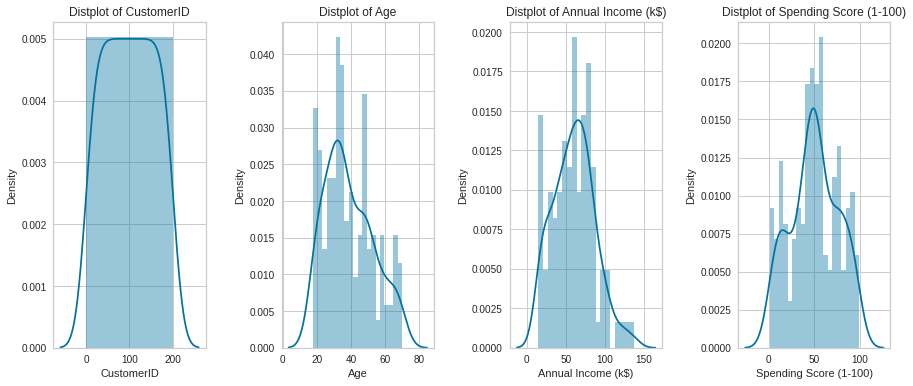

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df[['Gender']]

plt.figure(1,figsize=(15,6))
n=0
for x in num_cols:
    n+=1
    plt.subplot(1,4,n)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    sns.distplot(df[x],bins=20)
    plt.title('Distplot of {}'.format(x))
plt.show()

<Figure size 720x1080 with 0 Axes>

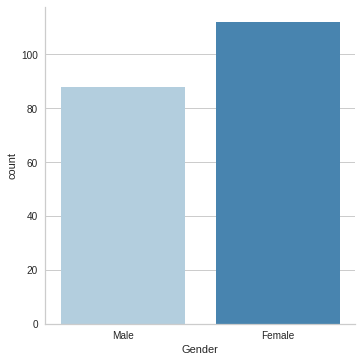

In [ ]:
plt.figure(figsize = (10,15))
sns.catplot(x='Gender', kind='count', palette='Blues', data = df)
plt.show()

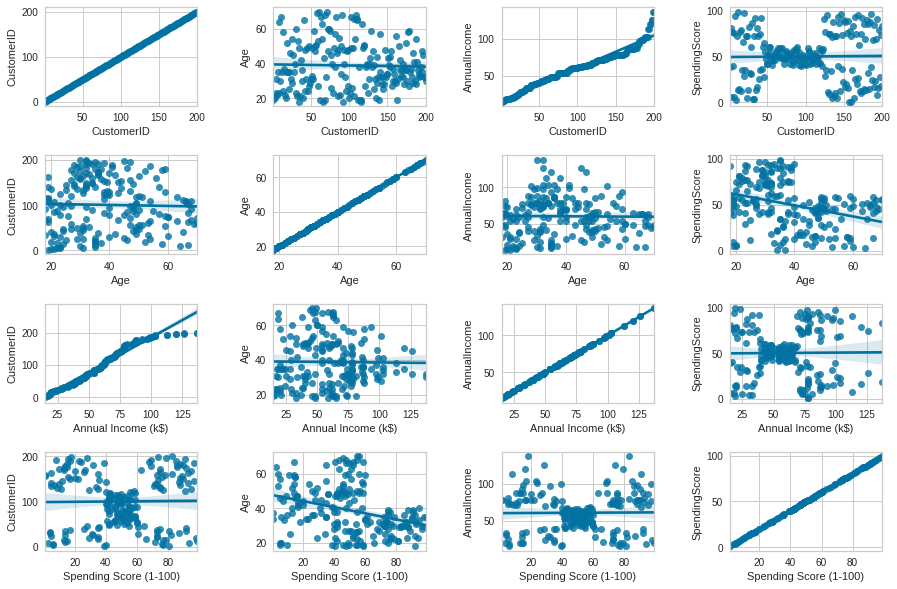

In [ ]:
plt.figure(1,figsize=(15,10))
n=0
for x in num_cols:
    for y in num_cols:
        n+=1
        plt.subplot(4,4,n)
        plt.subplots_adjust(hspace=0.5,wspace=0.5)
        sns.regplot(x=x,y=y,data=df)
        plt.ylabel(y.split()[0]+''+y.split()[1] if len(y.split())>1 else y)
plt.show()

위의 결과를 보면 Spending Score를 기준으로 고객을 세그먼트할 때 아마 5개 군집이 나오지 않을까?  
소득 높고 소비점수도 높은 그룹, 소득 높고 소비점수는 낮은 그룹, 소득 낮고 소비점수 높은 그룹, 소득 낮고 소비점수 낮은 그룹, 중간인 그룹..

소비 점수가 가장 높은 축에 속하는 사람들은 나이가 40세 아래에 속해있구나 신기하다..  
그렇다고 연봉이 높은 사람들이 나이가 40세 아래에 많은 건 아니다.. 대충 그래프를 보니 연봉이 낮으면서 소비점수는 높은 사람들은 40세 아래의 젊은 세대 중에 많이 있을 것 같네...

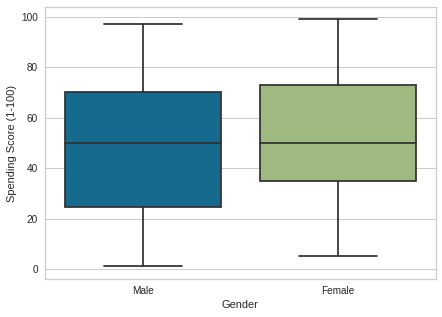

In [ ]:
## Spending Score와 성별은 어떤 관계가 있을까?

plt.figure(figsize=(7,5))
ax = sns.boxplot(x="Gender", y="Spending Score (1-100)", data=df)

뚜렷한 차이는 없지만 여자는 Spending Score의 1분위수가 남자보다 높다.  
그럼 Spending Score- Income 관계가 가장 정확히 보이니까 여기에 성별을 덧씌워서 성별이 군집 형성에 어떤 영향을 줄 수 있을지 한 번 봐보자..

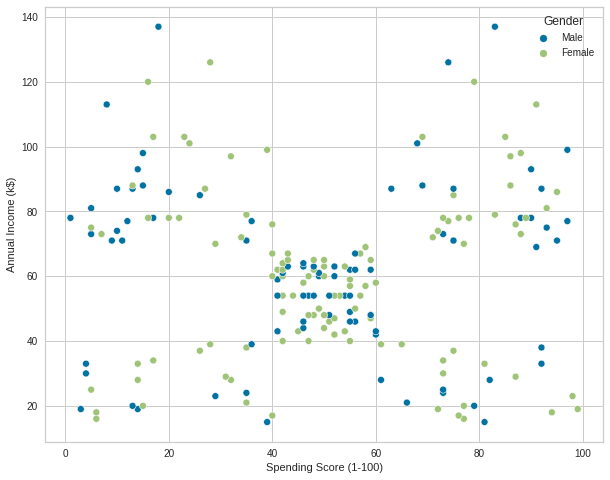

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x="Spending Score (1-100)", y="Annual Income (k$)", hue="Gender")

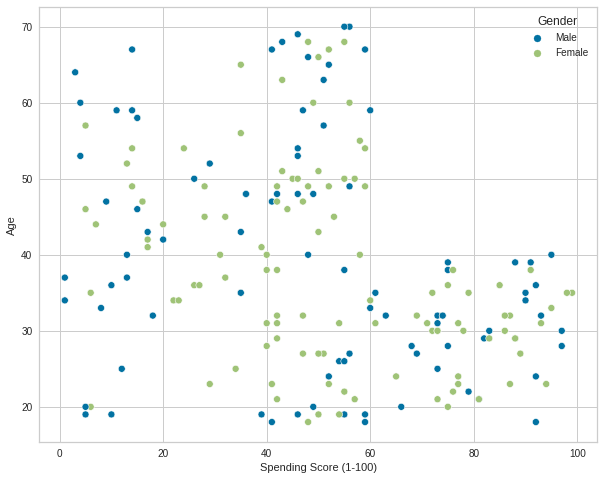

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x="Spending Score (1-100)", y="Age", hue="Gender")

성별이 뭔 관련이 있는지 잘 모르겠다

## 2. 군집분석 알고리즘 3가지를 이용한 고객 세그멘테이션
1. Hierarchical Clustering
2. non-Hierarchical Clustering
3. EM Algorithm
4. SOM (Self-Organizing Map)
5. 밀도기반 군집분석 DBSCAN
6. 격자기반 군집분석 

In [ ]:
## 소득, 소비점수를 이용해 군집화하자. (나이도 가능하겠지만 예쁘게 나오지 않을 듯)
x = df.iloc[:, [3, 4]].values

### (1) Hierarchical Clustering

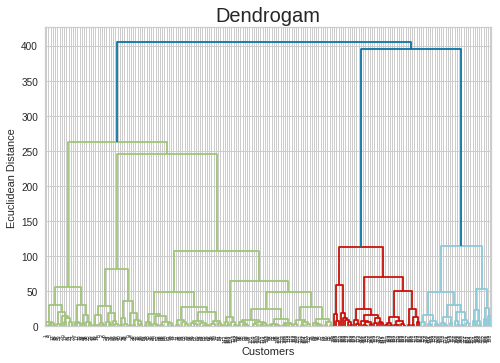

In [ ]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(x, method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

hcluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
label_hcluster = hcluster.fit_predict(x)

df['label_hcluster'] = label_hcluster

### (2) non-Hierarchical Clustering (K-Means)

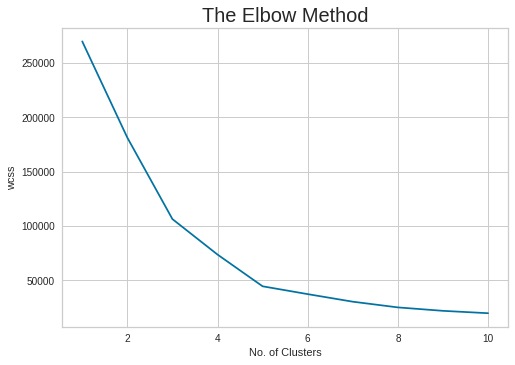

In [ ]:
## 최적의 k 개수 구하기
wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

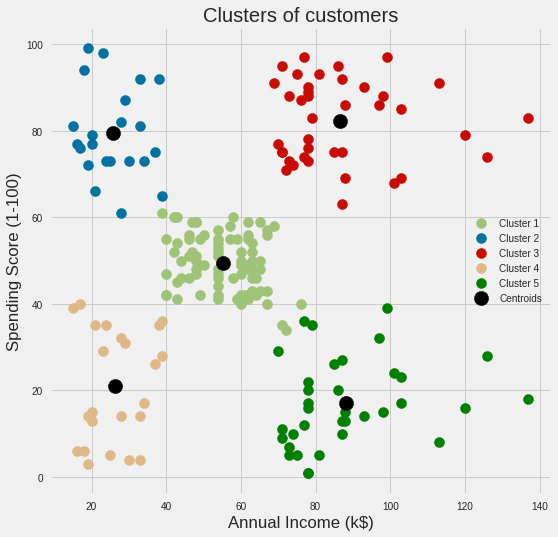

In [ ]:
## elbow가 클러스터 다섯개일 때 생기니까 k = 5로 결정
kmeanModel = KMeans(n_clusters=5,init='k-means++',max_iter=300,n_init=10,random_state=0)
y_kmeans= kmeanModel.fit_predict(x)

plt.figure(figsize=(8,8))
plt.scatter(x[y_kmeans == 0, 0], x[y_kmeans == 0, 1], s = 100, c = 'g', label = 'Cluster 1')
plt.scatter(x[y_kmeans == 1, 0], x[y_kmeans == 1, 1], s = 100, c = 'b', label = 'Cluster 2')
plt.scatter(x[y_kmeans == 2, 0], x[y_kmeans == 2, 1], s = 100, c = 'r', label = 'Cluster 3')
plt.scatter(x[y_kmeans == 3, 0], x[y_kmeans == 3, 1], s = 100, c = 'burlywood', label = 'Cluster 4')
plt.scatter(x[y_kmeans == 4, 0], x[y_kmeans == 4, 1], s = 100, c = 'green', label = 'Cluster 5')
plt.scatter(kmeanModel.cluster_centers_[:, 0], kmeanModel.cluster_centers_[:, 1], s = 200, c = 'black', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

In [ ]:
df['label_kmeans'] = y_kmeans # 성능평가를 위해서 저장해두고 다음으로 

### (3) EM Algorithm
EM 알고리즘에 대한 내용은 p.267에 자세히 나와있습니다. 
혼합분포는 데이터 분포가 k개의 모수적 모형 가중합으로 표현되는 모집단 모형으로 나왔다는 가정하에, 모수와 가중치를 추정하는 방법이라고 하네요.  
(여러개의 모수적 모형이 합쳐진 데이터 분포라는 게 헷갈렸는데, 책 예시대로 낙타 등처럼 봉이 여러개인 데이터 분포를 생각하면 이해하기 쉬운 것 같습니다. 그런 형태는 정규분포 여러개가 합쳐진 꼴로 생각할 수 있습니다.)  
조건부확률을 이용해 잠재변수 Z의 기댓값을 구하고 관측된 변수 X와 Z가 결합된 log-likelihood function을 이용한다고 하는데,, 
***솔직히 이 부분은 어떻게 계산이 되는거고 이게 어떻게 군집을 형성해주는지 제가 잘 이해가 안 가서 더 알아오도록 하겠습니다.***  

어쨌거나 저희에게 필요한 건 언제 쓰느냐인데, 일단 여러가지 분포가 결합된 모습으로 보일 때 사용한다는 것만 알아두면 될 것 같습니다.  




https://towardsdatascience.com/implement-expectation-maximization-em-algorithm-in-python-from-scratch-f1278d1b9137



### (4) SOM

In [ ]:
from som import Som


### (5) DBSCAN
산재한 데이터의 밀도 기반 탐색법으로
Eps는 각 데이터의 거리, MinPts는 그룹으로 취급받는 최소한의 밀도(모여있는 점의 개수)를 의미한다.

In [ ]:
from sklearn.cluster import DBSCAN

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x) ## normalize 안하면 거리가 너무 커서ㅠㅠ 클러스터가 안나옴

DBS_clustering = DBSCAN(eps=0.09, min_samples=5).fit(x_norm)  ## eps를 보통 어떻게 구하는지? 이걸 찾아봐야할 듯
DBSCAN_clustered = df.copy()
labels = DBS_clustering.labels_


n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
n_clusters_

5

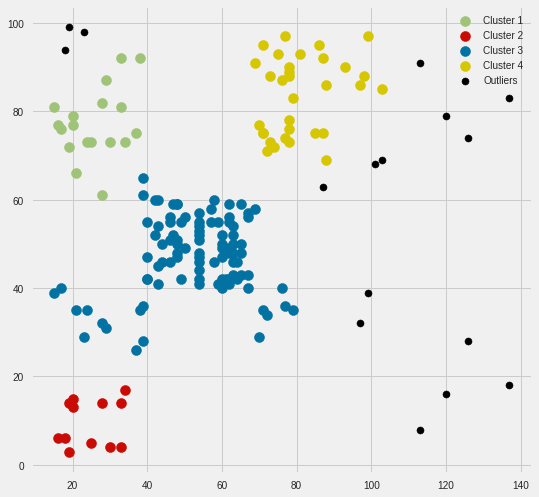

In [ ]:
colors = ['g','r','b','y','burlywood','green', 'm', 'c']
plt.figure(figsize=(8,8))
for i in range(0 ,n_clusters_ - 1):
    plt.scatter(x[labels == i, 0], x[labels == i, 1], s = 100, c = colors[i], label = 'Cluster ' + str(i + 1))
plt.scatter(x[labels == -1, 0], x[labels == -1, 1], s = 50, c = 'black', label = 'Outliers')    
plt.legend()

In [ ]:
df['label_dbscan'] = labels

##각 알고리즘별로 성능을 평가하시오
1. 실루엣
: 군집 내의 응집도와 군집 간 분리도룰 이용한 지표.  
{(i번째 개체와 다른 군집에 속한 요소들 간 거리 평균을 군집마다 구한 뒤, 그 평균의 최소값)- (i번째 개체와 같은 군집에 속한 요소들 간 거리 평균)} / 앞의 두 거리평균 중 최대값
-> 군집화가 완벽하면 1, 전혀 이루어지지 않았을 경우에는 -1의 값을 가지게 됨  
  
   
2. Dunn Index
: (군집간 거리의 최소값)/ (군집 내 요소 간 거리 최대값)
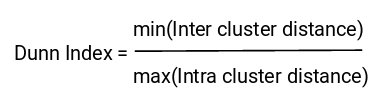
-> Dunn Index가 클수록 군집이 잘 형성되었다고 판단 가능

In [ ]:
## 1. 실루엣을 활용하기
from sklearn.metrics import silhouette_score

hclust_score = silhouette_score(df[['Annual Income (k$)','Spending Score (1-100)']] ,
                                df['label_hcluster'], metric='euclidean')
kmeans_score = silhouette_score(df[['Annual Income (k$)','Spending Score (1-100)']] ,
                                df.label_kmeans, metric='euclidean')
dbscan_score = silhouette_score(df[['Annual Income (k$)','Spending Score (1-100)']] ,
                                df['label_dbscan'], metric='euclidean')

In [ ]:
print("=========================================")
print("Hierarchical clustering silhouette score : ", hclust_score)
print("K Means clustering silhouette score : ", kmeans_score)
print("DBSCAN clustering silhouette score : ", dbscan_score)
print("=========================================")

Hierarchical clustering silhouette score :  0.4618340266628975
K Means clustering silhouette score :  0.553931997444648
DBSCAN clustering silhouette score :  0.4587977802780543


In [ ]:
!pip install validclust

In [ ]:
from sklearn.metrics import pairwise_distances
from validclust import dunn

dist = pairwise_distances(df[['Annual Income (k$)','Spending Score (1-100)']])
hclust_dunn = dunn(dist, df.label_hcluster)
kmeans_dunn = dunn(dist, df.label_kmeans)
dbscan_dunn = dunn(dist, df.label_dbscan)

In [ ]:
print("=========================================")
print("Hierarchical clustering Dunn Index : ", hclust_dunn)
print("K Means clustering Dunn Index : ", kmeans_dunn)
print("DBSCAN clustering Dunn Index : ", dbscan_dunn)
print("=========================================")

Hierarchical clustering Dunn Index :  0.11070066014527224
K Means clustering Dunn Index :  0.0584206237836986
DBSCAN clustering Dunn Index :  0.042499407740420936


군집분석 타당성을 확인하는 두 지표를 계산한 결과 Kmeans Clustering이 가장 잘 군집화하는 방법임

## 데이터 분석 결과를 기반으로 마케팅 인사이트를 제시하시오

나는 지금 Income 기반으로 클러스터링을 했는데, 실제로 마케팅 인사이트를 얻으려면 Income외에도 좀 유의미한 변수 처럼 보였던 Age를 활용한 클러스터링을 해보면 좋을 것 같다.
한편 boxplot과 Scatterplot을 봤을 땐 성별의 경우 딱히 차이점이 있는 것 같진 않았다.

Age의 경우 청년들의 소비점수가 높은 게 보였기 때문에, 백화점 입장에서 40대 이하 고객들을 공략할 방안을 찾으라고 제시할 수 있다.

Age로 클러스터링을 한번 더 해보면 될 듯..

Income은 플롯을 봤을 때 그다지 유의미한 인사이트가 나오진 않는다. 

In [ ]:
## 다차원 데이터